
## Régression logistique

_Fichier à modifier_ : [`logistic_regression.ipynb`](./logistic_regression.ipynb)

La régression logistique fonctionne un peu comme la régression linéaire, cependant c'est un problème de classification (ici binaire).

## Implémentation

1. Créer les données :
   1. Générer un jeu de données `S` de couples $(x, y)$ où $x \in \mathbb{R}^2$ et $y = \mathbf{1}_{w x + b > 0}$. Garder les paramètres $\theta := (w, b)$ pour la suite.
   2. Visualiser les données et la frontière $w x + b = 0$.
   3. Séparer les données en deux datasets : un jeu d'entraînement (`S_train`, 80 %) et un jeu de validation (`S_test`, 20 %).
2. Entraîner un modèle $\theta_0$ de régression logistique (`nn.Linear` + `nn.Sigmoid`) avec la perte _binary cross-entropy_ (`torch.nn.BCELoss`) et la descente de gradient stochastique (`torch.optim.SGD`).
3. Créer un nouveau jeu de données corrompu `S_corr` à partir `S` en appliquant du _label flipping_ à une fraction $\alpha \in [0, 1]$ des données $(x, y)$ : pour cette partie, on remplace le label $y$ par son opposé, $1 - y$.
4. Visualiser les données corrompues.
5. Créer un nouveau modèle  $\theta_1$ et l'entraîner sur ce nouveau jeu de données corrompu. Afficher la précision de $\theta_1$ sur `S_test`.
6. Dans les sous-questions suivantes, on va créer de **nouveaux** modèles avec des paramètres différents (écrire une fonction pour éviter de répéter le code de la question précédente). Afficher les différentes courbes de précision lorsque l'on fait varier un paramètre.
   1. Faire varier la valeur de $\alpha$.
   2. Créer un nouveau jeu de données de sorte que les valeurs de $x$ ne sont pas réparties uniformément, et refaire l'expérience. Par exemple, on concentre les valeurs de $x$ autour de $1$ ou plusieurs clusters (avec un mélange gaussien par exemple). Faire en sorte qu'au moins un des clusters soit proche de la frontière de classification. Que se passe-t-il ? On utilisera ce nouveau jeu de données dans la suite.
   3. Que se passe-t-il si l'on applique le _label flipping_ spécifiquement sur les points $x$ très proches de la frontière ?
   4. Faire varier la dimension de `x`.
7. _Bonus_ : que se passe-t-il si l'on rajoute des couches (_hidden layers_) ?
8. _Bonus_ : que se passe-t-il avec peu de données ?
9.  _Bonus_ : que se passe-t-il si au lieu de créer un nouveau modèle $\theta_1$, on continue l'entraînement du modèle $\theta$ sur `S_corr` ?

## Analyse
   1. Faire le lien avec les chapitres sur la classification dans le cours de Statistiques.
   2. Expliquer brièvement le concept du mélange gaussien.
   3. Établir une relation empirique entre l'imprécision du modèle et la proportion de points "proches" de la frontière.
   4. Faire le lien avec le concept du jailbreaking. Pour illustration, voir la slide 26 : _Évasion (jailbreaking)_ de la [conférence de Lê Nguyên Hoang en décembre 2024](https://science4all.org/wp-content/uploads/2024/12/piaf.pdf)
   5. Établir une relation empirique entre l'imprécision du modèle et la dimension de `x`.
   6. Peut-on imaginer un moyen d'identifier l'empoisonnement, de filtrer les données suspicieuses ou d'agréger les gradients d'un mini-batch de manière robuste ? Exemple d'approche sur [Scikit-Learn](https://scikit-learn-extra.readthedocs.io/en/stable/modules/robust.html)

In [313]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
import numpy as np


## Generate the dataset

In [254]:
X = torch.randn((1000, 2))
X1 = X[:, 0]
X2 = X[:, 1]
W = torch.randn(1)

b = torch.randn(1)

Z = W * X1 + b
y = (X2 > Z).int().float()

S=TensorDataset(X,y)

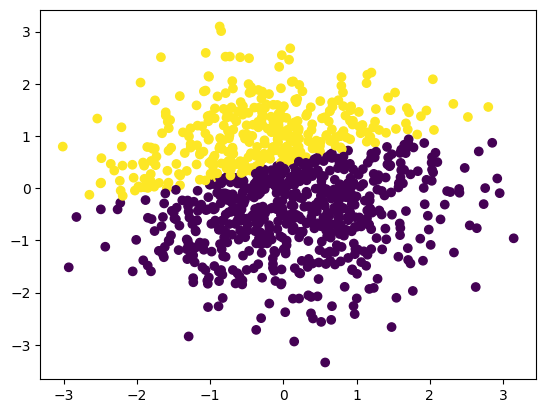

In [255]:
plt.scatter(X1, X2, c=y)

### Separation variable entrainement variable validation

In [256]:

N=len(S)

S_train, S_test = random_split(S,[int(0.8*N),int(0.2*N)])


batch_size = 16
train_loader = DataLoader(S_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(S_test, batch_size=batch_size)



### Définition du Modèle

In [257]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Couche linéaire

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Sigmoïde pour la probabilité
    
model = LogisticRegressionModel(input_dim=2)  # 2 caractéristiques

In [271]:
# 3. Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Descente de gradient

### Entrainement

Epoch 10/100, Loss: 0.0619, Val Loss: 0.0940
Epoch 20/100, Loss: 0.1613, Val Loss: 0.0933
Epoch 30/100, Loss: 0.0686, Val Loss: 0.0925
Epoch 40/100, Loss: 0.0702, Val Loss: 0.0918
Epoch 50/100, Loss: 0.0519, Val Loss: 0.0911
Epoch 60/100, Loss: 0.1129, Val Loss: 0.0905
Epoch 70/100, Loss: 0.0664, Val Loss: 0.0898
Epoch 80/100, Loss: 0.0254, Val Loss: 0.0892
Epoch 90/100, Loss: 0.1061, Val Loss: 0.0886
Epoch 100/100, Loss: 0.0991, Val Loss: 0.0880


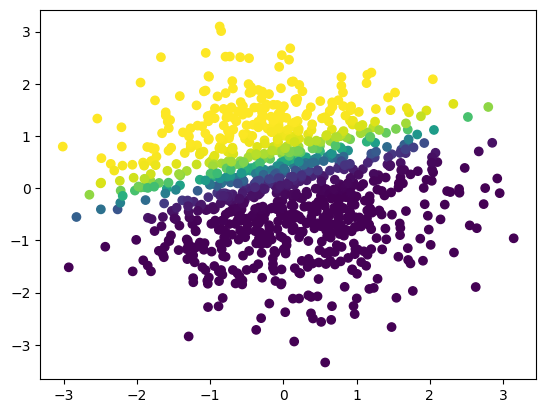

In [273]:
epochs = 100
for epoch in range(epochs):
    model.train()  # Mode entraînement
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    if (epoch + 1) % 10 == 0:
        model.eval()  # Mode évaluation
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()
                val_loss += criterion(outputs, labels).item()
        
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

model.eval()
plt.scatter(X1,X2,c = model(S[:][0]).detach().clone())

### Jeu de données Corrompu

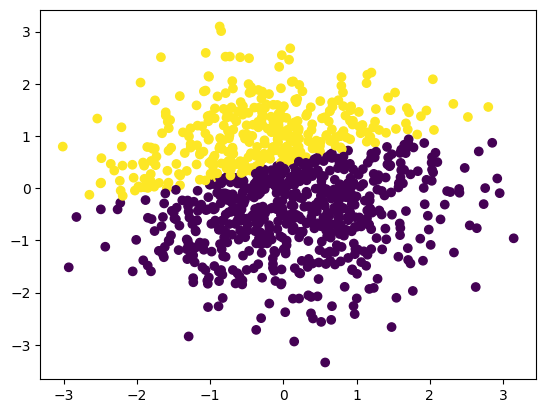

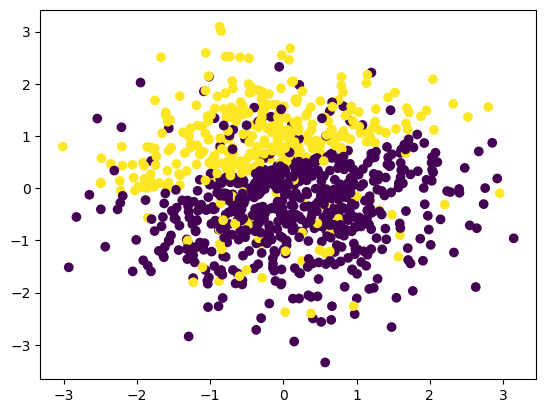

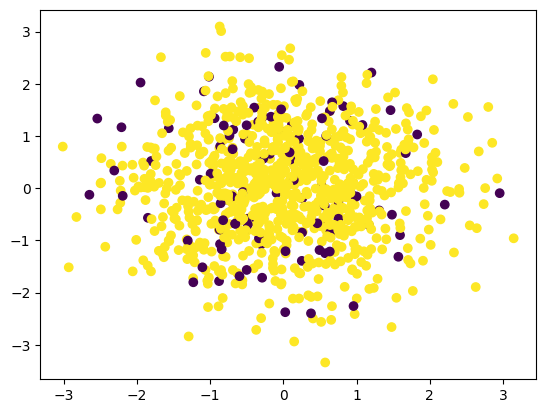

In [277]:
alpha = 0.1

# Calculer combien de labels inverser
num_labels_to_flip = int(alpha * N)

# Sélectionner aléatoirement les indices à inverser
flip_indices = np.random.choice(N, num_labels_to_flip, replace=False)

Y_corr = y.clone()


Y_corr[flip_indices] = 1 - Y_corr[flip_indices]

S_corr = TensorDataset(X,Y_corr)

plt.figure(1)
plt.scatter(X1, X2, c=y)
plt.figure(2)
plt.scatter(X1, X2, c=Y_corr)
plt.figure(3)
plt.scatter(X1,X2, c=(y==Y_corr))



### Entrainement sur les données corrompus

In [278]:
S_Corr_train, S_Corr_test = random_split(S_corr,[int(0.8*N),int(0.2*N)])

train_loader = DataLoader(S_Corr_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(S_Corr_test, batch_size=batch_size)



model1 = LogisticRegressionModel(input_dim=2)  # 2 caractéristiques

epochs = 100
for epoch in range(epochs):
    model1.train()  # Mode entraînement
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model1(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    if (epoch + 1) % 10 == 0:
        model1.eval()  # Mode évaluation
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model1(inputs).squeeze()
                val_loss += criterion(outputs, labels).item()
        
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

Epoch 10/100, Loss: 0.8954, Val Loss: 0.9216
Epoch 20/100, Loss: 0.8670, Val Loss: 0.9216
Epoch 30/100, Loss: 0.7941, Val Loss: 0.9216
Epoch 40/100, Loss: 0.8251, Val Loss: 0.9216
Epoch 50/100, Loss: 0.9260, Val Loss: 0.9216
Epoch 60/100, Loss: 0.7896, Val Loss: 0.9216
Epoch 70/100, Loss: 0.7790, Val Loss: 0.9216
Epoch 80/100, Loss: 0.8081, Val Loss: 0.9216
Epoch 90/100, Loss: 0.9154, Val Loss: 0.9216
Epoch 100/100, Loss: 0.8425, Val Loss: 0.9216


##### Fonction de précision

In [308]:
def accuracy(model, dataloader):
    model.eval()  # Met le modèle en mode évaluation
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradient
        for inputs, labels in dataloader:
            outputs = model(inputs)  # Prédictions du modèle
            # Appliquer un seuil de 0.5 pour la classification binaire
            predicted = (outputs > 0.5).float()  # Sortie 0 ou 1 selon le seuil

            total += 1  # Nombre total d'exemples
            correct += (predicted == labels).sum().item()  # Nombre de prédictions correctes

    accuracy = correct / total  # Précision
    return accuracy

## Précision des différents modèles sur S_test

In [310]:
print(accuracy(model,S_test))
print(accuracy(model1, S_test))


0.995
0.255


# Variation de alpha

### Fonction de Corruption

In [311]:
def createCorrSet (dataloader, alpha_):
    # Calculer combien de labels inverser
    num_to_flip = int(alpha_ * N)

    # Sélectionner aléatoirement les indices à inverser
    flip_indices = np.random.choice(N, num_to_flip, replace=False)

    Y_c = y.clone()
    Y_c[flip_indices] = 1 - Y_c[flip_indices]

    return TensorDataset(X,Y_c)

### Fonction Train

In [315]:
def tr_Model (S_,model_a):
    
    S_tr, S_te = random_split(S_,[int(0.8*N),int(0.2*N)])

    train_loader = DataLoader(S_tr, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(S_te, batch_size=batch_size)
    
    

    epochs = 100
    for epoch in range(epochs):
        model_a.train()  # Mode entraînement
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model_a(inputs).squeeze()
            loss = criterion(outputs, labels)
        
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # Validation
        if (epoch + 1) % 10 == 0:
            model_a.eval()  # Mode évaluation
            val_loss = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model_a(inputs).squeeze()
                    val_loss += criterion(outputs, labels).item()

## Précision en fonction du pourcentage de corruption

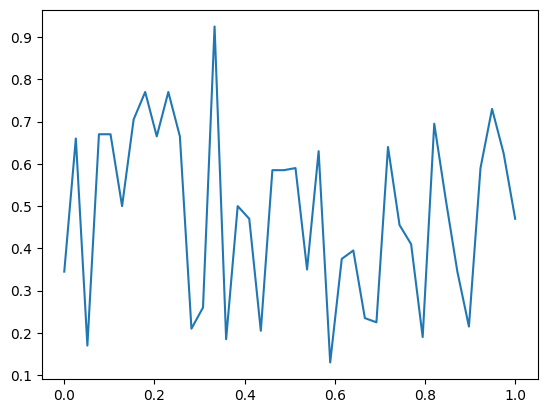

In [ ]:
acc=[]
for alpha_ in np.linspace(0,1,40):
    S_c = createCorrSet(S,alpha_)                       #On crée un nv dataset corrompu
    model_a = LogisticRegressionModel(input_dim=2)      #On crée un nv modèle
    tr_Model(S_c,model_a)                               #On l'entraine
    acc.append(accuracy(model_a, S_test))               #on teste sa précision

plt.plot(np.linspace(0,1,40),acc)
